# Data Generation and Statistical Test


In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import os 
import sys
sys.path.append('../')

import Util.data_check

## Data Preparation

In [2]:
data_path1 = '../Data/'
data_path2 = '../data/'

# Check which path exists
if os.path.exists(data_path1):
    data_path = data_path1
elif os.path.exists(data_path2):
    data_path = data_path2
else:
    raise FileNotFoundError("Neither data_path1 nor data_path2 exists")

In [3]:
# set random seed for reproducibility
np.random.seed(42)

# Daten laden
file_name = 'preprocessed_df_v2.csv'
file_path = os.path.join(data_path, file_name)

data = pd.read_csv(file_path)

In [4]:
data.head()

,participant_id,test_id,test_duration,mental,physical,temporal,performance,effort,frustration,mean,...,fixationrate_rel,fixationrate_rel_pct,mean_pupil_diameter_rel,mean_pupil_diameter_rel_pct,median_pupil_diameter_rel,median_pupil_diameter_rel_pct,visual_acuity_logmar,gender,age,education
0,1,1,33.643950,10,5,15,25,25,10,15.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.04,0,28,18
1,1,2,28.484322,50,30,25,50,15,25,32.5,...,-0.120413,-40.687440,-0.919996,-2.097788,-0.872377,-1.987465,-0.04,0,28,18
2,1,3,71.423823,100,10,75,80,90,20,62.5,...,-0.099928,-33.765546,0.848925,1.935731,0.897654,2.045050,-0.04,0,28,18
3,1,4,38.163442,60,15,45,50,20,25,35.8,...,-0.007684,-2.596309,1.906622,4.347507,1.951494,4.445927,-0.04,0,28,18
4,2,1,41.748047,20,10,20,10,20,15,15.8,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.10,0,28,18


In [5]:
print(data.columns.to_list())

['participant_id', 'test_id', 'test_duration', 'mental', 'physical', 'temporal', 'performance', 'effort', 'frustration', 'mean', 'mean_pupil_diameter', 'median_pupil_diameter', 'blinkrate', 'fixationrate', 'blinkrate_rel', 'blinkrate_rel_pct', 'fixationrate_rel', 'fixationrate_rel_pct', 'mean_pupil_diameter_rel', 'mean_pupil_diameter_rel_pct', 'median_pupil_diameter_rel', 'median_pupil_diameter_rel_pct', 'visual_acuity_logmar', 'gender', 'age', 'education']


In [6]:
# Entfernen der berechneten relativen Features 
columns_to_drop = ['blinkrate_rel', 'blinkrate_rel_pct', 'fixationrate_rel', 'fixationrate_rel_pct', 'mean_pupil_diameter_rel', 'mean_pupil_diameter_rel_pct', 'median_pupil_diameter_rel', 'median_pupil_diameter_rel_pct']
data = data.drop(columns_to_drop, axis=1)
print(data.columns.to_list())

['participant_id', 'test_id', 'test_duration', 'mental', 'physical', 'temporal', 'performance', 'effort', 'frustration', 'mean', 'mean_pupil_diameter', 'median_pupil_diameter', 'blinkrate', 'fixationrate', 'visual_acuity_logmar', 'gender', 'age', 'education']


In [7]:
discrete_columns = ['gender', 'education', 'age']  
continuous_columns = [col for col in data.columns if col not in discrete_columns]

In [8]:
def scale_data(df_to_scale, continuous_columns, discrete_columns, duration_column, num_additional_points=1000):
    """
    Scale continuous data using MinMaxScaler and generate synthetic data
    without negative values in the duration column.
    """
    
    # Scale data
    scaler = MinMaxScaler()
    data_continuous_scaled = scaler.fit_transform(df_to_scale[continuous_columns])
    
    # Generate synthetic continuous data
    means = np.mean(data_continuous_scaled, axis=0)
    stds = np.std(data_continuous_scaled, axis=0)

    # Generate synthetic data for all columns except the duration column
    synthetic_data_continuous_scaled = np.random.normal(loc=means, scale=stds, size=(num_additional_points, data_continuous_scaled.shape[1]))
    
    # Ensure positive values for the duration column
    duration_column_index = continuous_columns.index(duration_column)
    original_durations_scaled = data_continuous_scaled[:, duration_column_index]
    duration_mean = np.mean(original_durations_scaled)
    duration_std = np.std(original_durations_scaled)
    
    synthetic_duration_data_scaled = np.random.normal(loc=duration_mean, scale=duration_std, size=num_additional_points)
    synthetic_duration_data_scaled = np.clip(synthetic_duration_data_scaled, 0, None)  # Set negative values to zero
    synthetic_data_continuous_scaled[:, duration_column_index] = synthetic_duration_data_scaled
    
    # Inverse transform to get the original scale
    synthetic_data_continuous = scaler.inverse_transform(synthetic_data_continuous_scaled)
    synthetic_data_continuous_df = pd.DataFrame(synthetic_data_continuous, columns=continuous_columns)
    
    # Calculate distributions for discrete columns
    discrete_distributions = {col: df_to_scale[col].value_counts(normalize=True) for col in discrete_columns}
    
    # Generate synthetic discrete data based on distributions
    synthetic_data_discrete = {}
    for col in discrete_columns:
        values = discrete_distributions[col].index.tolist()
        probabilities = discrete_distributions[col].values.tolist()
        synthetic_data_discrete[col] = np.random.choice(values, size=num_additional_points, p=probabilities)
    
    # Convert synthetic discrete data to DataFrame
    synthetic_data_discrete_df = pd.DataFrame(synthetic_data_discrete)
    
    # Combine synthetic continuous and discrete data
    synthetic_data_combined_df = pd.concat([synthetic_data_continuous_df, synthetic_data_discrete_df], axis=1)
    
    return synthetic_data_combined_df


In [9]:
test_1_df = data[data['test_id'] == 1]
test_2_df = data[data['test_id'] == 2]
test_3_df = data[data['test_id'] == 3]
test_4_df = data[data['test_id'] == 4]

# Generate synthetic data for each test
synth_data_1 = scale_data(test_1_df, continuous_columns, discrete_columns, 'test_duration')
synth_data_2 = scale_data(test_2_df, continuous_columns, discrete_columns, 'test_duration')
synth_data_3 = scale_data(test_3_df, continuous_columns, discrete_columns, 'test_duration')
synth_data_4 = scale_data(test_4_df, continuous_columns, discrete_columns, 'test_duration')

# check data of each test
#Util.data_check.compare_distributions(test_1_df, synth_data_1)
#Util.data_check.compare_distributions(test_2_df, synth_data_2)
#Util.data_check.compare_distributions(test_3_df, synth_data_3)
#Util.data_check.compare_distributions(test_4_df, synth_data_4)


In [10]:
# replace participant_id with new values
max_participant_id = max(data['participant_id'].values)
synth_data_1['participant_id'] = synth_data_1.index + max_participant_id + 1
synth_data_2['participant_id'] = synth_data_2.index + max_participant_id + 1
synth_data_3['participant_id'] = synth_data_3.index + max_participant_id + 1
synth_data_4['participant_id'] = synth_data_4.index + max_participant_id + 1


In [11]:
# Combine generated data 
synthetic_data = pd.concat([synth_data_1, synth_data_2, synth_data_3, synth_data_4], ignore_index=True)


# Output shapes
print("Original Data Shape:", data.shape)
print("Synthetic Data Shape:", synthetic_data.shape)

Original Data Shape: (188, 18)
Synthetic Data Shape: (4000, 18)


In [12]:
# Check if the participant_id is unique
print("Number of unique participant_id in original data:", data['participant_id'].nunique())
print("Number of unique participant_id in synthetic data:", synthetic_data['participant_id'].nunique())

# sort by participant_id and test_id and reset index
synthetic_data= synthetic_data.sort_values(by=['participant_id', 'test_id']).reset_index(drop=True)

# Ausgabe der ersten 5 Zeilen
print(synthetic_data[188:197])

Number of unique participant_id in original data: 47
Number of unique participant_id in synthetic data: 1000
     participant_id  test_id  test_duration     mental   physical   temporal  \
188              95      1.0      42.595358 -12.412005  47.235879  21.977888   
189              95      2.0      16.067415  60.873625  24.019382  42.351867   
190              95      3.0      24.645579  87.906840 -13.779035  67.869461   
191              95      4.0     812.353186  69.223485  11.881243  68.851554   
192              96      1.0      54.186766  39.078173  19.299116  16.085000   
193              96      2.0      37.033932  32.617807  18.398790  54.858449   
194              96      3.0    1688.931727  57.876969  52.714704  53.402247   
195              96      4.0      27.707877  78.054693 -19.389103  57.407968   
196              97      1.0      45.254014  55.885792  34.745451  -8.633611   

     performance     effort  frustration       mean  mean_pupil_diameter  \
188    14.8680

In [13]:
def ensure_consistent_values(df, id_column, consistency_columns):
    """
    Ensure that values in the consistency_columns are the same for each unique id_column.
    If not, correct them to the most common value.
    """
    def correct_group(group):
        for col in consistency_columns:
            if group[col].nunique() > 1:
                most_common_value = group[col].mode()[0]
                group[col] = most_common_value
        return group
    
    # Group by id_column and correct each group
    corrected_df = df.groupby(id_column, group_keys=False).apply(correct_group, include_groups=False)
    
    # Ensure 'age' is an integer
    corrected_df['age'] = corrected_df['age'].astype(int)
    
    # Re-add the id_column to the corrected DataFrame
    corrected_df[id_column] = df[id_column].values
    
    # Ensure id_column is the first column
    cols = [id_column] + [col for col in corrected_df.columns if col != id_column]
    corrected_df = corrected_df[cols]
    
    return corrected_df

In [14]:
# Definieren der Spaltennamen
id_column = 'participant_id'
consistency_columns = ['gender', 'education', 'age', 'visual_acuity_logmar']

# Prüfe ob pro participant_id das gleiche Geschlecht, Bildung, Alter und Sehschärfe vorliegt
print("Werte vor Korrektur:")
print(synthetic_data.groupby('participant_id')[consistency_columns].nunique().max())

# Konsistenz der Werte sicherstellen
synthetic_data = ensure_consistent_values(synthetic_data, id_column, consistency_columns)

# prüfe ob pro participant_id das gleiche Geschlecht, Bildung, Alter und Sehschärfe vorliegt
print("Werte nach Korrektur:")
print(synthetic_data.groupby('participant_id')[consistency_columns].nunique().max())

Werte vor Korrektur:
gender                  2
education               4
age                     4
visual_acuity_logmar    4
dtype: int64
Werte nach Korrektur:
gender                  1
education               1
age                     1
visual_acuity_logmar    1
dtype: int64


In [15]:
synthetic_data.head()

,participant_id,test_id,test_duration,mental,physical,temporal,performance,effort,frustration,mean,mean_pupil_diameter,median_pupil_diameter,blinkrate,fixationrate,visual_acuity_logmar,gender,education,age
0,48,1.0,37.819741,53.289688,11.882375,15.336775,48.494476,42.287798,5.073329,25.948093,30.731630,30.648150,0.073688,0.146211,-0.237871,0,18,40
1,48,2.0,23.156731,55.455952,6.217212,14.562209,18.505854,24.811791,2.839859,53.281932,44.571901,32.361351,0.039789,0.277645,-0.237871,0,18,40
2,48,3.0,24.645579,84.830430,32.920665,26.097066,17.818988,65.184365,23.206510,48.184696,34.256731,34.351829,0.302210,0.282545,-0.237871,0,18,40
3,48,4.0,27.707877,80.690926,72.031000,51.834699,20.554931,55.655628,38.267889,49.866840,46.797834,31.594688,0.156504,0.322461,-0.237871,0,18,40
4,49,1.0,39.351644,8.982846,-9.692023,40.695320,12.278443,28.170566,-9.930026,12.898108,33.328767,27.628573,0.083855,0.232277,-0.171326,1,18,21


In [16]:
# Clamp synthetic data to the original data, ignore `participant_id` and `test_id`

columns_to_clamp = [col for col in data.columns if col not in ['participant_id', 'test_id']]
min_values = data[columns_to_clamp].min()
max_values = data[columns_to_clamp].max()

synthetic_df_clamped = synthetic_data.copy()
synthetic_df_clamped[columns_to_clamp] = synthetic_data[columns_to_clamp].clip(lower=min_values, upper=max_values, axis=1)

In [17]:
synthetic_data.describe()

,participant_id,test_id,test_duration,mental,physical,temporal,performance,effort,frustration,mean,mean_pupil_diameter,median_pupil_diameter,blinkrate,fixationrate,visual_acuity_logmar,gender,education,age
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,547.500000,2.500000,275.816955,50.324702,22.563599,39.816474,32.699296,48.037667,24.670870,36.473913,34.852745,34.761628,0.156883,0.277629,-0.184853,0.225000,16.685000,25.581000
std,288.711081,1.118174,515.303075,28.867442,22.729596,28.026954,24.672301,27.770954,23.920913,19.488877,5.210636,5.226703,0.185051,0.068547,0.054784,0.417635,1.850576,6.502308
min,48.000000,1.000000,11.256207,-39.063010,-51.187690,-51.615820,-57.196345,-42.293225,-61.325173,-18.705902,15.478027,16.242619,-0.400518,0.004813,-0.364323,0.000000,12.000000,18.000000
25%,297.750000,1.750000,26.941570,28.727808,7.447996,19.731292,15.467608,28.297392,8.143398,21.870356,31.256303,31.157614,0.023820,0.232789,-0.219111,0.000000,16.000000,19.000000
50%,547.500000,2.500000,35.593134,49.740696,21.799401,37.526330,30.875248,48.550920,22.235445,35.152073,34.777588,34.496223,0.097168,0.275921,-0.180006,0.000000,16.000000,24.000000
75%,797.250000,3.250000,188.767345,72.302206,36.797414,58.083718,48.682854,68.182113,38.803471,49.897739,38.194950,38.273218,0.270359,0.321432,-0.146144,0.000000,18.000000,29.000000
max,1047.000000,4.000000,3461.560953,136.547747,117.430523,157.862059,123.143212,128.559790,133.733624,102.325143,53.154722,50.934052,0.912631,0.618369,-0.021953,1.000000,21.000000,47.000000


In [18]:
data.describe()

,participant_id,test_id,test_duration,mental,physical,temporal,performance,effort,frustration,mean,mean_pupil_diameter,median_pupil_diameter,blinkrate,fixationrate,visual_acuity_logmar,gender,age,education
count,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000
mean,24.000000,2.500000,124.467726,50.239362,22.420213,39.095745,32.420213,48.244681,25.085106,36.252660,34.841518,34.738427,0.157245,0.276538,-0.102766,0.446809,31.489362,17.042553
std,13.600881,1.121019,726.105618,29.206459,22.936066,27.903221,25.010565,27.732560,24.023678,19.469453,5.269522,5.195801,0.185095,0.067758,0.078535,0.498490,7.618925,2.159000
min,1.000000,1.000000,11.256207,5.000000,5.000000,5.000000,0.000000,5.000000,5.000000,4.200000,25.644326,25.583751,0.000000,0.000000,-0.290000,0.000000,18.000000,12.000000
25%,12.000000,1.750000,31.020867,25.000000,5.000000,15.000000,10.000000,25.000000,5.000000,21.700000,31.054235,31.085921,0.022739,0.232809,-0.160000,0.000000,25.000000,16.000000
50%,24.000000,2.500000,42.294795,50.000000,12.500000,30.000000,27.500000,50.000000,15.000000,35.400000,33.783967,33.724105,0.081957,0.277894,-0.080000,0.000000,30.000000,18.000000
75%,36.000000,3.250000,60.270482,75.000000,25.000000,55.000000,50.000000,70.000000,35.000000,50.000000,37.903275,37.631562,0.227108,0.322440,-0.050000,1.000000,38.000000,18.000000
max,47.000000,4.000000,7249.677538,100.000000,100.000000,100.000000,95.000000,100.000000,100.000000,84.200000,50.119098,50.139223,0.947007,0.552124,0.100000,1.000000,47.000000,21.000000


In [19]:
# # Getrennte DataFrames für Original- und generierte Daten
# original_df = data.copy()
# synthetic_df = augmented_data.iloc[len(data):].copy()

# Getrennte DataFrames für Original- und generierte Daten
original_df = data.copy()
synthetic_df = synthetic_data.iloc[len(data):].copy()

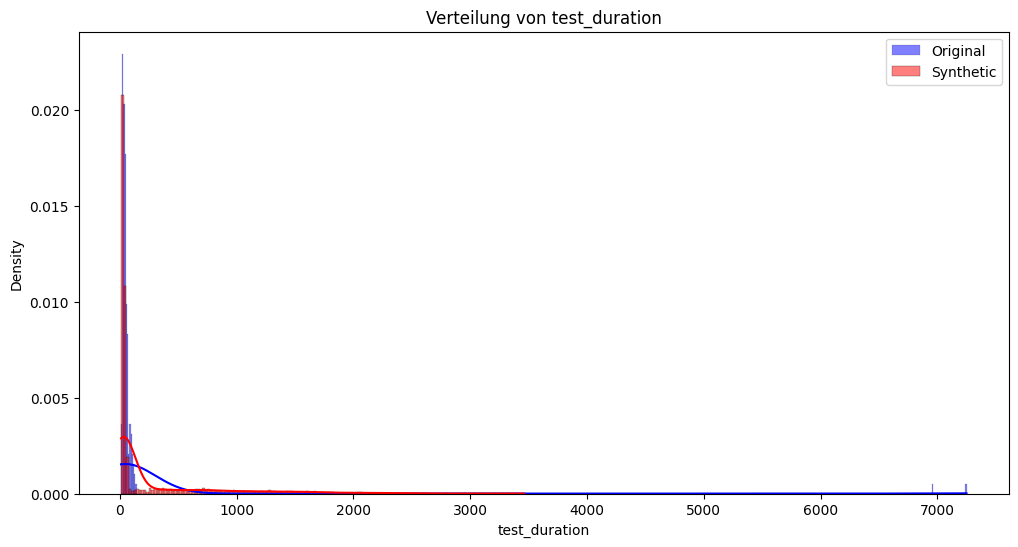

Normalitätstest für test_duration:
Originaldaten: Nicht-normalverteilt
Generierte Daten: Nicht-normalverteilt
Kruskal-Wallis H-Test für test_duration:
Statistik = 2.237481067963464, p-Wert = 0.13470025476825387
Die Verteilungen sind ähnlich (Nullhypothese nicht verworfen).



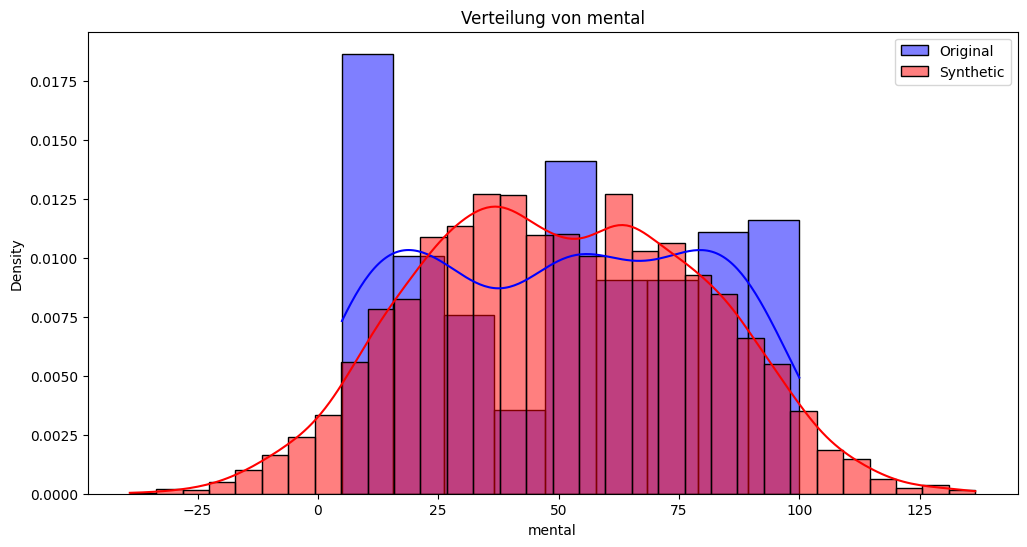

Normalitätstest für mental:
Originaldaten: Nicht-normalverteilt
Generierte Daten: Nicht-normalverteilt
Kruskal-Wallis H-Test für mental:
Statistik = 0.0010885352814978052, p-Wert = 0.9736802032404946
Die Verteilungen sind ähnlich (Nullhypothese nicht verworfen).



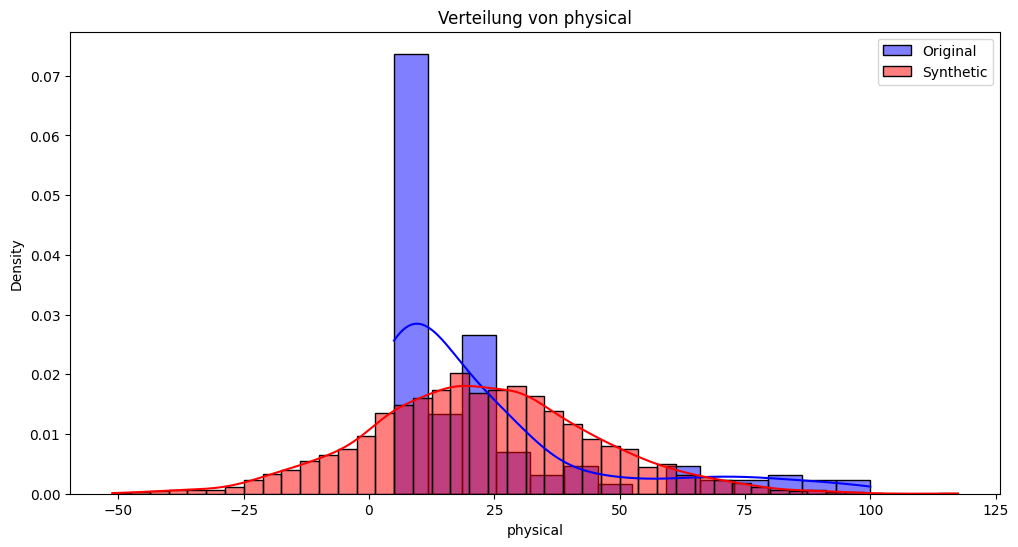

Normalitätstest für physical:
Originaldaten: Nicht-normalverteilt
Generierte Daten: Nicht-normalverteilt
Kruskal-Wallis H-Test für physical:
Statistik = 5.615050752714984, p-Wert = 0.017806865404862524
Die Verteilungen sind signifikant unterschiedlich (Nullhypothese verworfen).



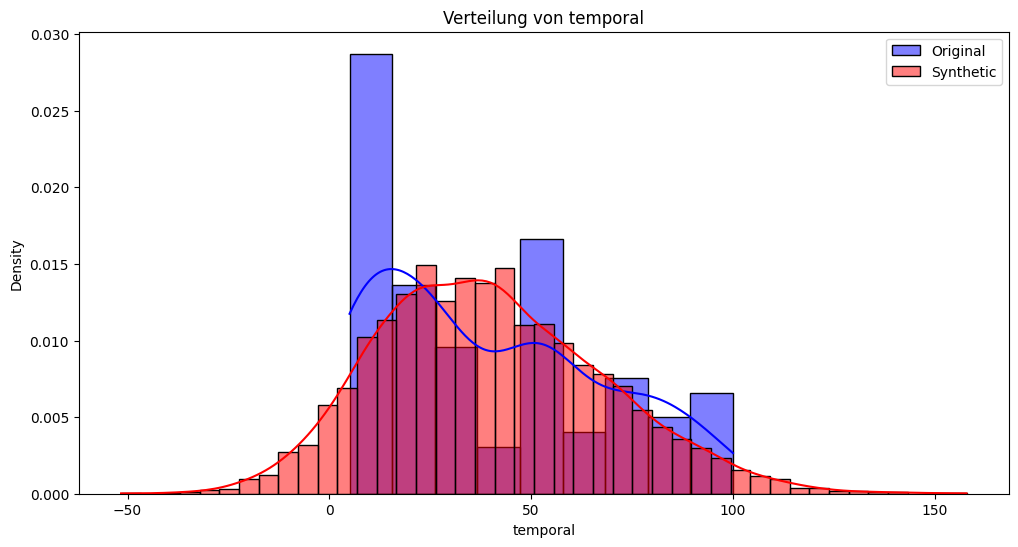

Normalitätstest für temporal:
Originaldaten: Nicht-normalverteilt
Generierte Daten: Nicht-normalverteilt
Kruskal-Wallis H-Test für temporal:
Statistik = 0.7610342436554912, p-Wert = 0.38300505244506733
Die Verteilungen sind ähnlich (Nullhypothese nicht verworfen).



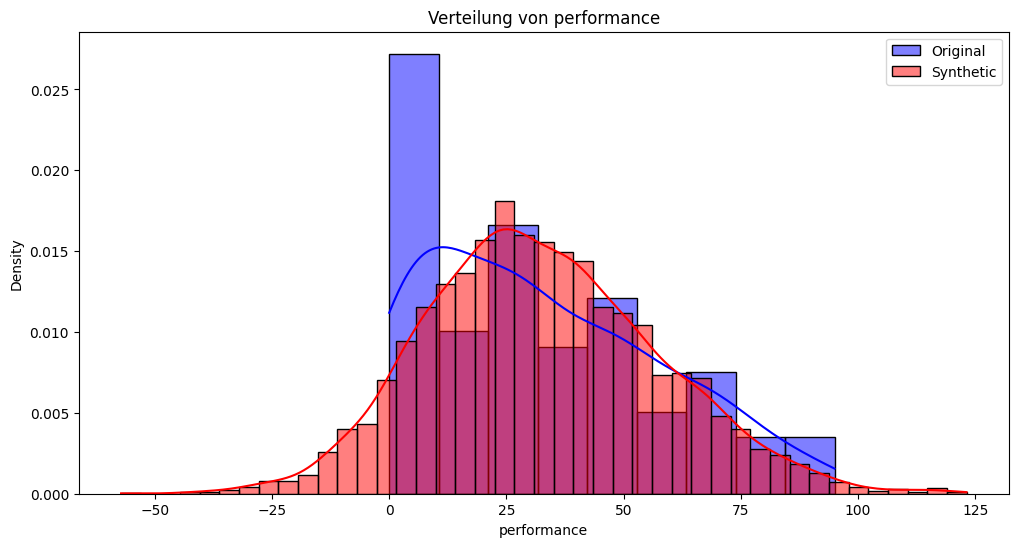

Normalitätstest für performance:
Originaldaten: Nicht-normalverteilt
Generierte Daten: Nicht-normalverteilt
Kruskal-Wallis H-Test für performance:
Statistik = 0.5670327940291158, p-Wert = 0.4514404199708313
Die Verteilungen sind ähnlich (Nullhypothese nicht verworfen).



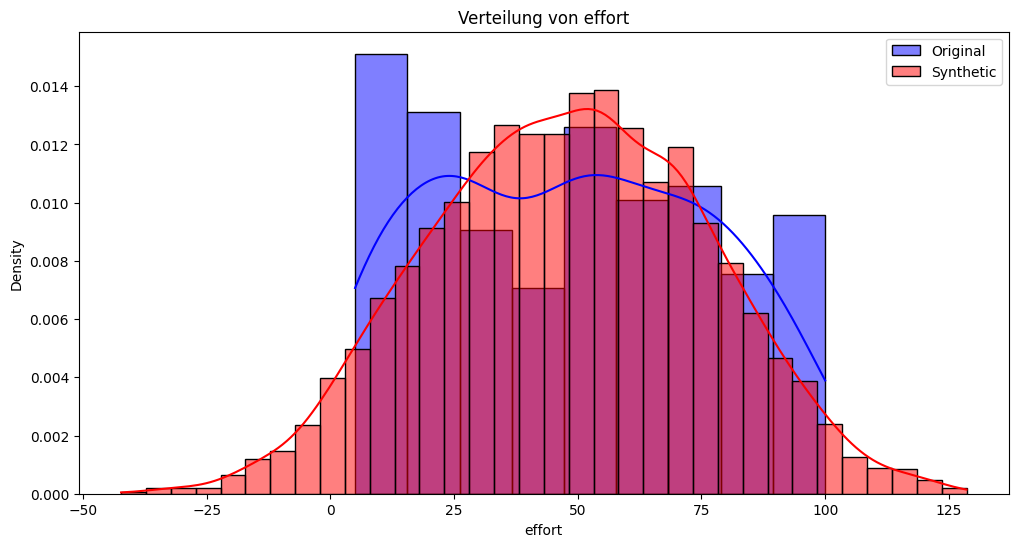

Normalitätstest für effort:
Originaldaten: Nicht-normalverteilt
Generierte Daten: Nicht-normalverteilt
Kruskal-Wallis H-Test für effort:
Statistik = 0.004578945669869327, p-Wert = 0.9460499970472898
Die Verteilungen sind ähnlich (Nullhypothese nicht verworfen).



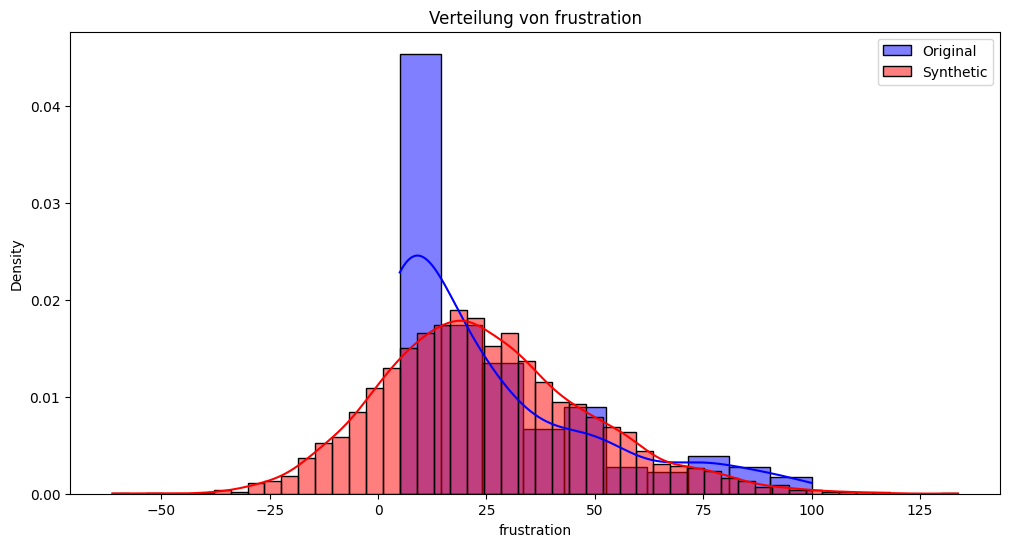

Normalitätstest für frustration:
Originaldaten: Nicht-normalverteilt
Generierte Daten: Nicht-normalverteilt
Kruskal-Wallis H-Test für frustration:
Statistik = 1.3466403673781213, p-Wert = 0.2458663120943894
Die Verteilungen sind ähnlich (Nullhypothese nicht verworfen).



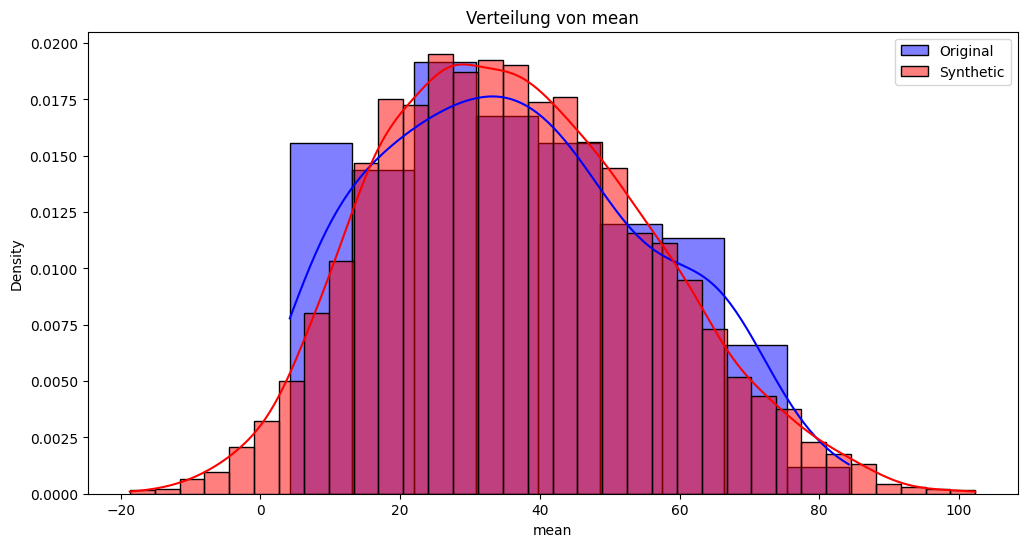

Normalitätstest für mean:
Originaldaten: Nicht-normalverteilt
Generierte Daten: Nicht-normalverteilt
Kruskal-Wallis H-Test für mean:
Statistik = 0.0568607558727159, p-Wert = 0.8115282642139015
Die Verteilungen sind ähnlich (Nullhypothese nicht verworfen).



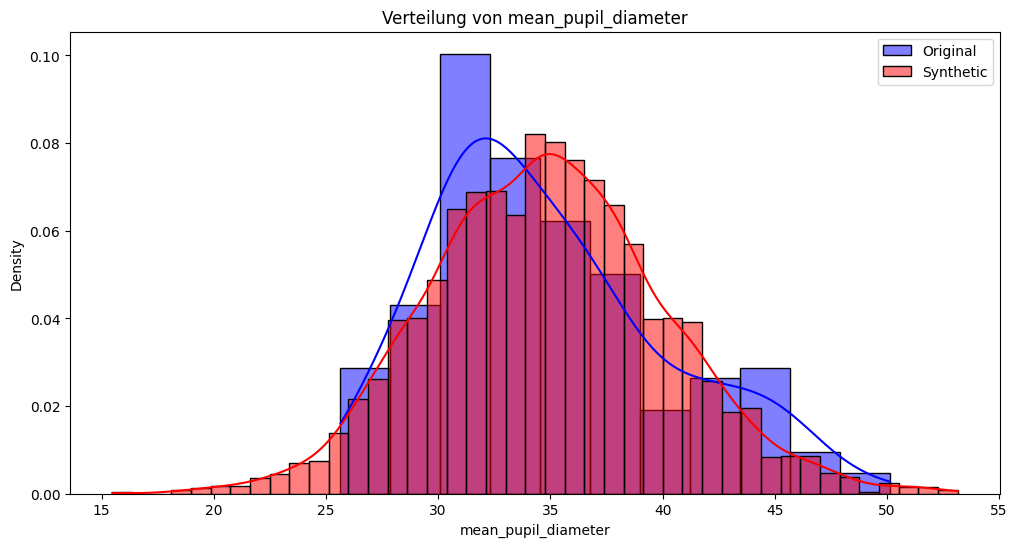

Normalitätstest für mean_pupil_diameter:
Originaldaten: Nicht-normalverteilt
Generierte Daten: Nicht-normalverteilt
Kruskal-Wallis H-Test für mean_pupil_diameter:
Statistik = 0.8294378988139135, p-Wert = 0.36243511678171936
Die Verteilungen sind ähnlich (Nullhypothese nicht verworfen).



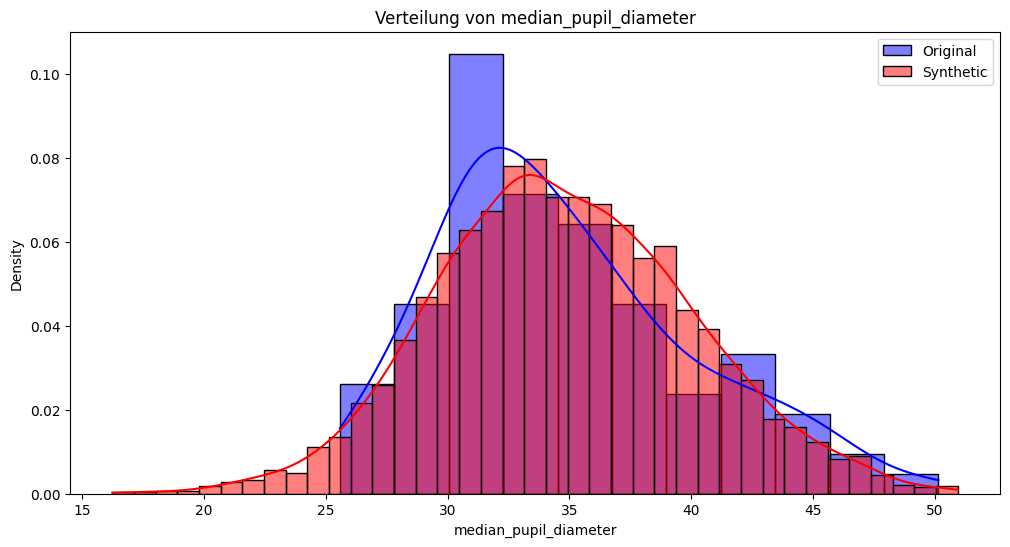

Normalitätstest für median_pupil_diameter:
Originaldaten: Nicht-normalverteilt
Generierte Daten: Nicht-normalverteilt
Kruskal-Wallis H-Test für median_pupil_diameter:
Statistik = 0.7913534822239748, p-Wert = 0.37369117575843613
Die Verteilungen sind ähnlich (Nullhypothese nicht verworfen).



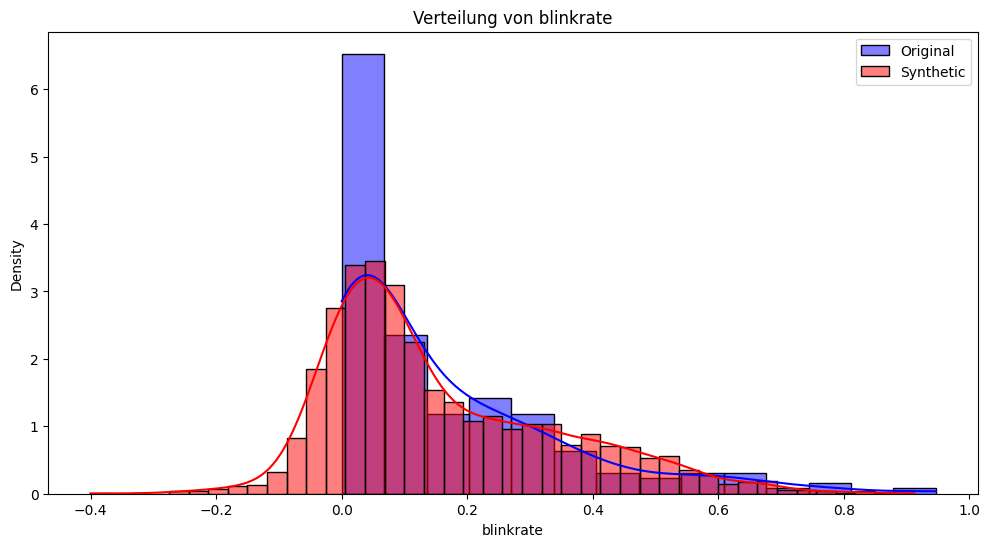

Normalitätstest für blinkrate:
Originaldaten: Nicht-normalverteilt
Generierte Daten: Nicht-normalverteilt
Kruskal-Wallis H-Test für blinkrate:
Statistik = 0.06177561488838583, p-Wert = 0.8037112041689636
Die Verteilungen sind ähnlich (Nullhypothese nicht verworfen).



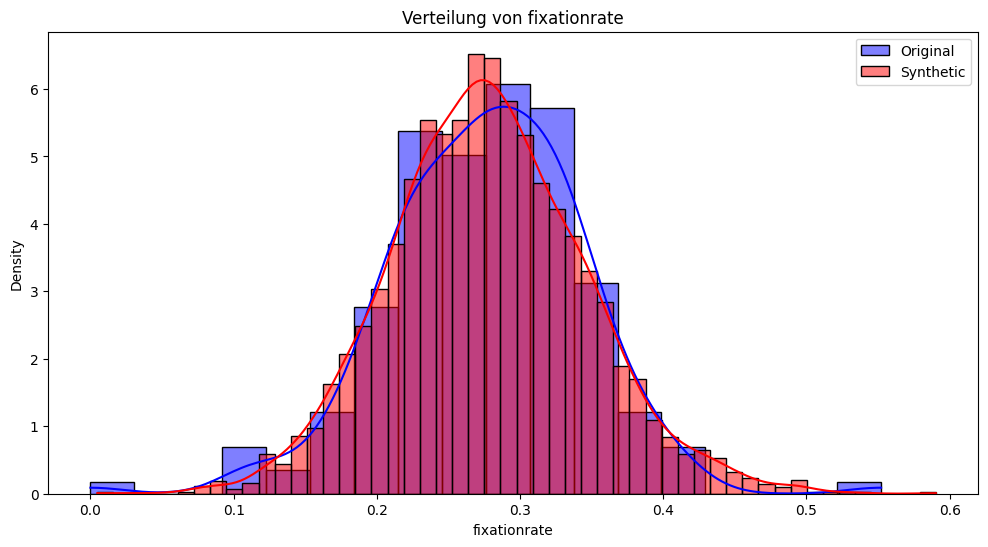

Normalitätstest für fixationrate:
Originaldaten: Nicht-normalverteilt
Generierte Daten: Nicht-normalverteilt
Kruskal-Wallis H-Test für fixationrate:
Statistik = 0.04409597854481173, p-Wert = 0.8336751462616844
Die Verteilungen sind ähnlich (Nullhypothese nicht verworfen).



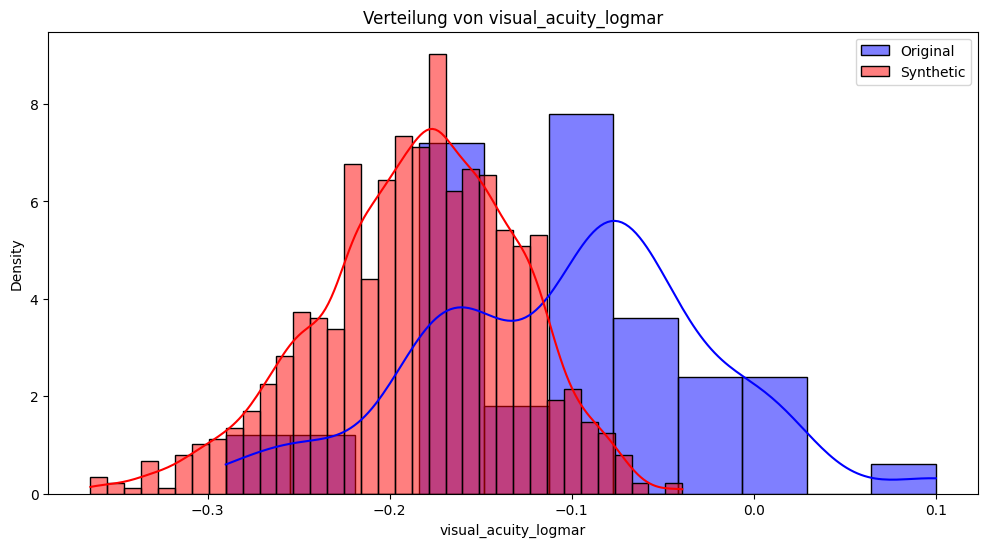

Normalitätstest für visual_acuity_logmar:
Originaldaten: Nicht-normalverteilt
Generierte Daten: Nicht-normalverteilt
Kruskal-Wallis H-Test für visual_acuity_logmar:
Statistik = 199.6658071500313, p-Wert = 2.4703617539167573e-45
Die Verteilungen sind signifikant unterschiedlich (Nullhypothese verworfen).



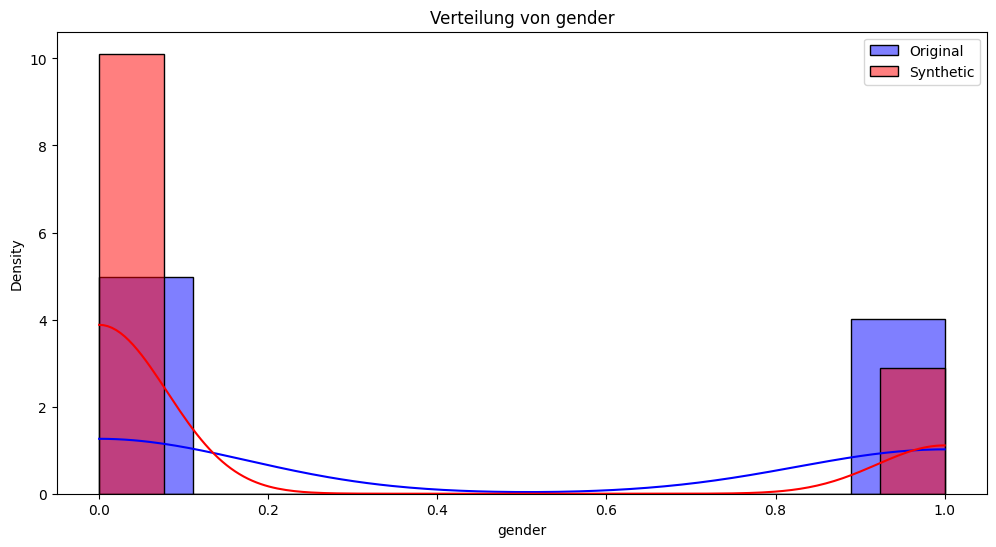

Normalitätstest für gender:
Originaldaten: Nicht-normalverteilt
Generierte Daten: Nicht-normalverteilt
Kruskal-Wallis H-Test für gender:
Statistik = 50.44928935863247, p-Wert = 1.2228407717718014e-12
Die Verteilungen sind signifikant unterschiedlich (Nullhypothese verworfen).



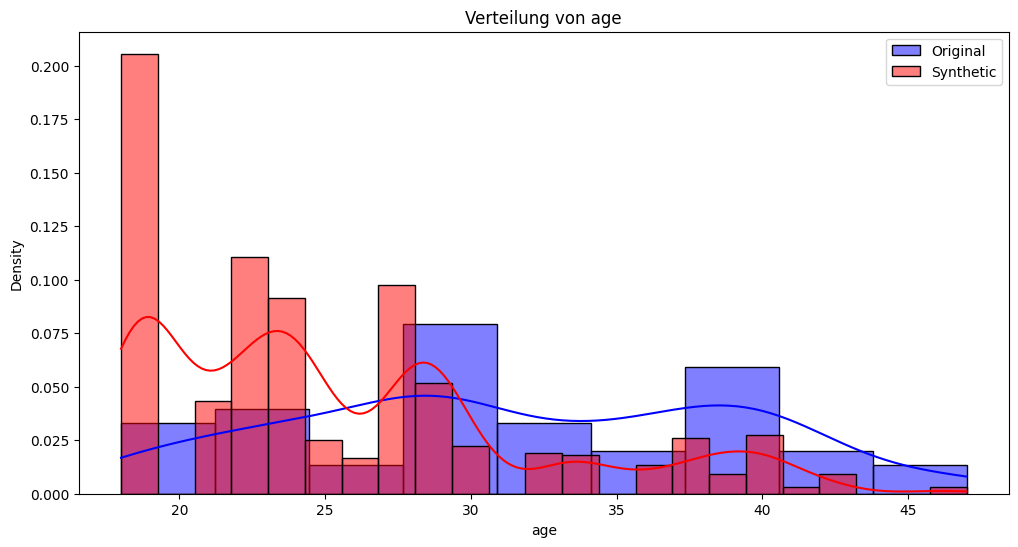

Normalitätstest für age:
Originaldaten: Nicht-normalverteilt
Generierte Daten: Nicht-normalverteilt
Kruskal-Wallis H-Test für age:
Statistik = 111.71083731150264, p-Wert = 4.134167067977799e-26
Die Verteilungen sind signifikant unterschiedlich (Nullhypothese verworfen).



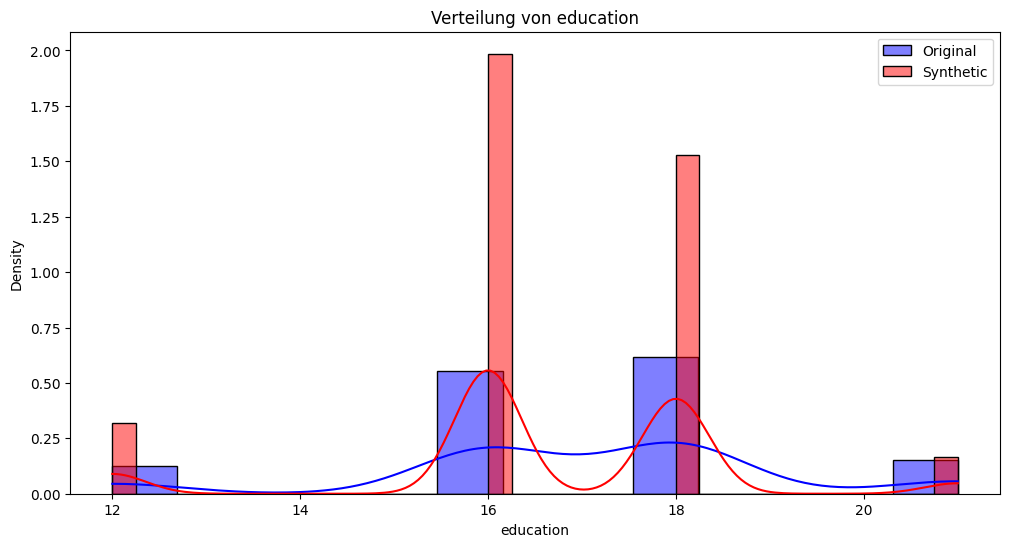

Normalitätstest für education:
Originaldaten: Nicht-normalverteilt
Generierte Daten: Nicht-normalverteilt
Kruskal-Wallis H-Test für education:
Statistik = 9.240287929319866, p-Wert = 0.0023674772433405003
Die Verteilungen sind signifikant unterschiedlich (Nullhypothese verworfen).



In [20]:
# Werte prüfen. Ausgabe als Plot und Text
Util.data_check.compare_distributions(original_df, synthetic_df)

In [21]:
# Append synthetic data to original data
augmented_data = pd.concat([data, synthetic_data])
augmented_data.sort_values(by=['participant_id', 'test_id']).reset_index(drop=True)

,participant_id,test_id,test_duration,mental,physical,temporal,performance,effort,frustration,mean,mean_pupil_diameter,median_pupil_diameter,blinkrate,fixationrate,visual_acuity_logmar,gender,age,education
0,1,1.0,33.643950,10.000000,5.000000,15.000000,25.000000,25.000000,10.000000,15.000000,43.855534,43.893976,0.059446,0.295946,-0.040000,0,28,18
1,1,2.0,28.484322,50.000000,30.000000,25.000000,50.000000,15.000000,25.000000,32.500000,42.935538,43.021599,0.000000,0.175533,-0.040000,0,28,18
2,1,3.0,71.423823,100.000000,10.000000,75.000000,80.000000,90.000000,20.000000,62.500000,44.704459,44.791630,0.196013,0.196018,-0.040000,0,28,18
3,1,4.0,38.163442,60.000000,15.000000,45.000000,50.000000,20.000000,25.000000,35.800000,45.762156,45.845470,0.052406,0.288263,-0.040000,0,28,18
4,2,1.0,41.748047,20.000000,10.000000,20.000000,10.000000,20.000000,15.000000,15.800000,31.492393,31.393101,0.000000,0.143727,-0.100000,0,28,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4183,1046,4.0,27.707877,39.798454,11.214817,25.109891,92.427839,57.483732,21.652150,47.448349,36.492477,34.306299,0.047207,0.363167,-0.232313,1,24,16
4184,1047,1.0,47.619951,41.047935,10.361097,38.986240,35.135160,31.090630,16.225326,15.785105,28.713782,38.151801,0.155049,0.213691,-0.172340,0,29,16
4185,1047,2.0,29.557659,61.956543,3.839574,26.379201,25.326836,120.427633,30.447809,30.174834,37.371068,31.213610,0.048437,0.371897,-0.172340,0,29,16
4186,1047,3.0,24.645579,53.823571,-12.354254,22.813909,43.872952,42.695197,44.786436,31.207549,26.669802,32.890701,0.307439,0.199966,-0.172340,0,29,16


In [22]:
# save the augmented data
augmented_data.to_csv(os.path.join(data_path, 'augmented_data.csv'), index=False)

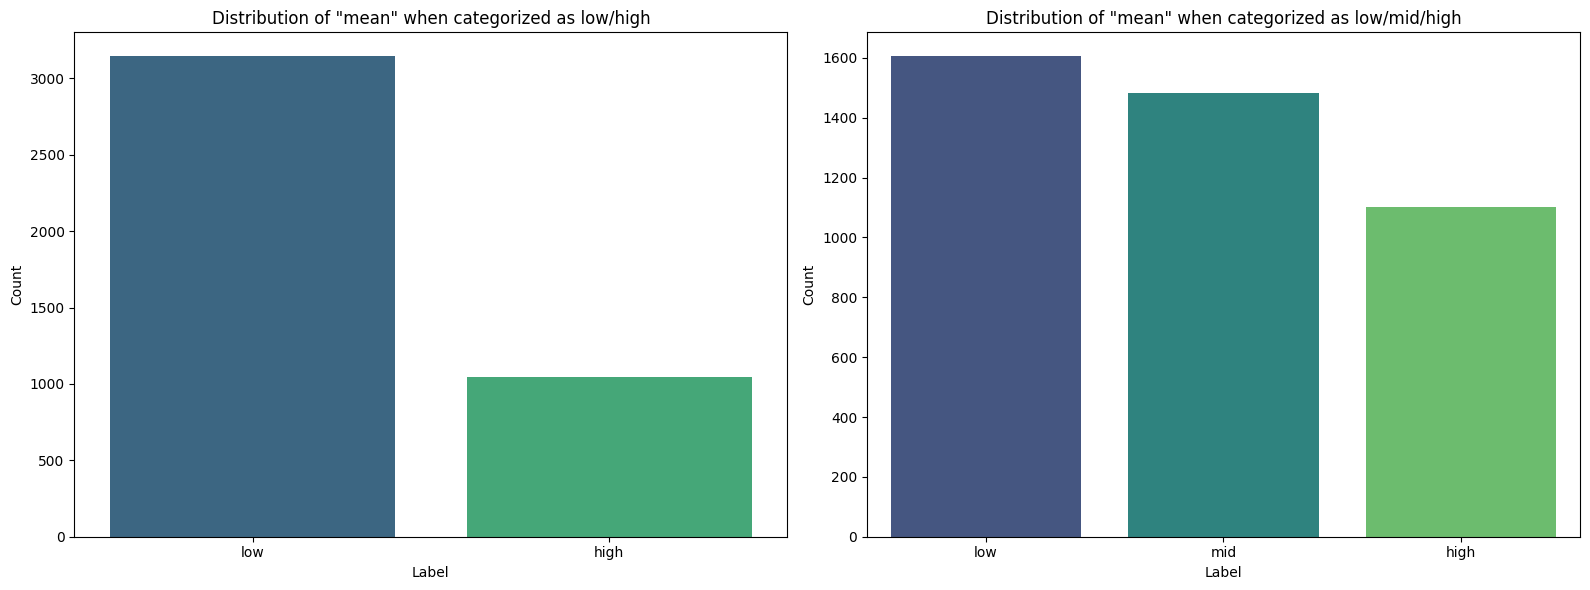

In [23]:
# Lets check balance of the `mean` column when categorized as low/mid/high and low/high
import matplotlib.pyplot as plt
import seaborn as sns

# Multicalss thresholds taken from COLET Paper
y_multiclass = augmented_data['mean'].apply(lambda x: 'low' if x <= 29 else ('mid' if x <= 49 else 'high'))
y_binary = augmented_data['mean'].apply(lambda x: 'low' if x <= 50 else 'high')

fig, axs = plt.subplots(1, 2, figsize=(16, 6))

sns.countplot(x=y_binary, hue=y_binary, palette='viridis', legend=False, ax=axs[0])
axs[0].set_title('Distribution of "mean" when categorized as low/high')
axs[0].set_xlabel('Label')
axs[0].set_ylabel('Count')

sns.countplot(x=y_multiclass, hue=y_multiclass, palette='viridis', legend=False, ax=axs[1])
axs[1].set_title('Distribution of "mean" when categorized as low/mid/high')
axs[1].set_xlabel('Label')
axs[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

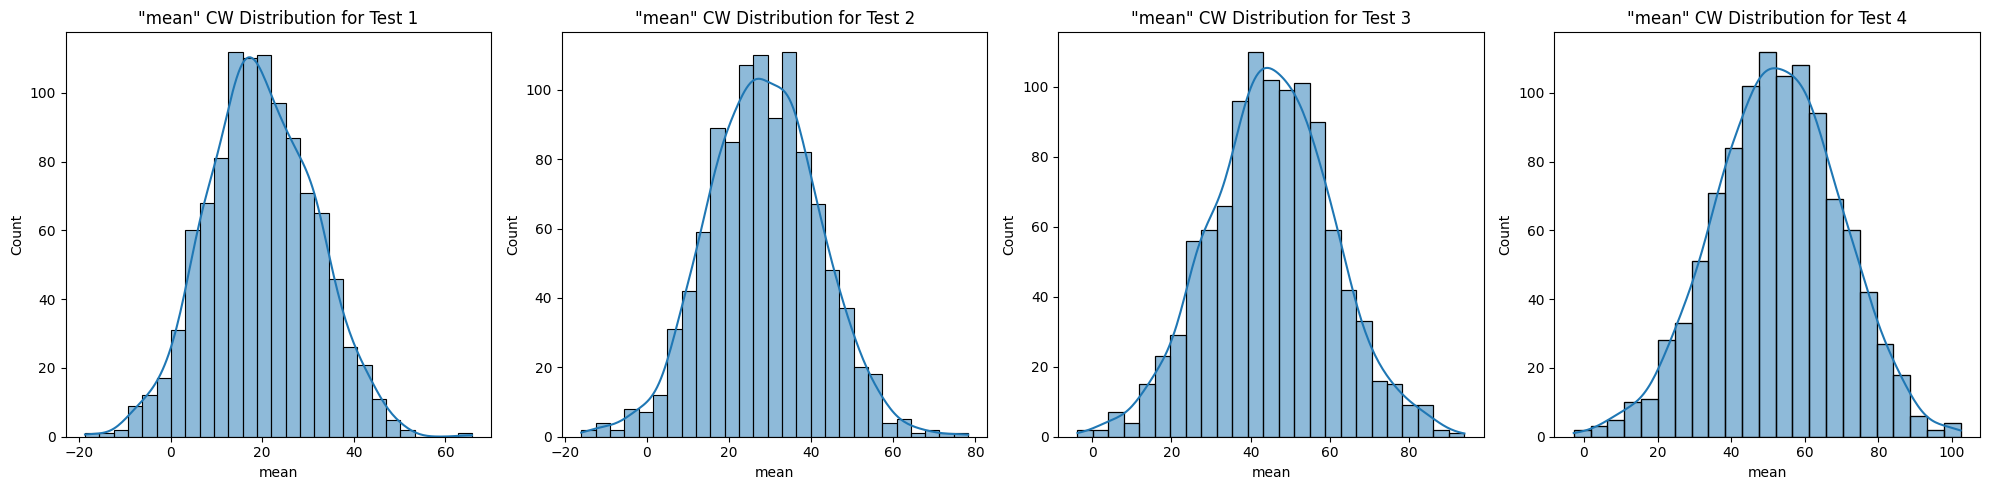

In [24]:
# Compare augmented distributions of mean per test

# Check distribution of 'mean' for different test types
data_filtered = augmented_data[['test_id', 'mean']]

plt.figure(figsize=(20, 5))  
for i, test_id in enumerate(range(1, 5), 1):
    plt.subplot(1, 4, i)  
    sns.histplot(data=data_filtered[data_filtered['test_id'] == test_id], x='mean', kde=True)
    plt.title(f'"mean" CW Distribution for Test {test_id}')
plt.tight_layout()
plt.show()